# 01 - 用户分析 (User Table) — 2025年至今

分析 OSAIO (`bi_center`) 和 Nooie (`nooie_bi_center`) 的 `user` 表

**数据范围：2025-01-01 至今**

**分析维度：**
1. 用户注册趋势（按日/周/月）
2. 用户来源分析（自购设备注册 vs 被分享设备）
3. 注册国家/地区分布
4. 用户增长率
5. OSAIO vs Nooie 对比

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

from src.db.connector import DBConnector

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

/Users/petercheng/Library/Python/3.9/lib/python/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/Users/petercheng/Library/Python/3.9/lib/python/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [2]:
# 建立连接
db = DBConnector(brand='osaio')
db.connect()
print('Connected to:', db.database)

Connected to: bi_center


## 1. 加载数据

In [3]:
# 加载两个品牌的用户数据（2025年以后）
# 2025-01-01 00:00:00 UTC = 1735689600
sql = """
SELECT 
    uid,
    register_time,
    register_country,
    country_iso
FROM user
WHERE register_time >= 1735689600
"""

# OSAIO
df_osaio = db.query_df(sql)
df_osaio['brand'] = 'OSAIO'
print(f'OSAIO: {len(df_osaio):,} rows')

# Nooie
db.switch_database('nooie')
df_nooie = db.query_df(sql)
df_nooie['brand'] = 'Nooie'
print(f'Nooie: {len(df_nooie):,} rows')

# 合并
df = pd.concat([df_osaio, df_nooie], ignore_index=True)
print(f'Total: {len(df):,} rows')

# 预处理
df['register_date'] = pd.to_datetime(df['register_time'], unit='s')
df['register_month'] = df['register_date'].dt.to_period('M')
df['register_week'] = df['register_date'].dt.to_period('W')

print(f"时间范围: {df['register_date'].min()} ~ {df['register_date'].max()}")
df.head()

OSAIO: 194,048 rows
Nooie: 58,974 rows
Total: 253,022 rows
时间范围: 2025-01-01 00:12:45 ~ 2026-02-16 20:27:44


,uid,register_time,register_country,country_iso,brand,register_date,register_month,register_week
0,euK0f6r1a0a6r6q0,1756332963,44,,OSAIO,2025-08-27 22:16:03,2025-08,2025-08-25/2025-08-31
1,euK7C0Y0a0a6r7W0,1762924427,33,,OSAIO,2025-11-12 05:13:47,2025-11,2025-11-10/2025-11-16
2,euK7f2a2m0a6r5q9,1760810648,43,,OSAIO,2025-10-18 18:04:08,2025-10,2025-10-13/2025-10-19
3,eul0a0a0a0s7s5m9,1752603210,44,,OSAIO,2025-07-15 18:13:30,2025-07,2025-07-14/2025-07-20
4,eul0a0a0a1a4t2m9,1756750006,33,,OSAIO,2025-09-01 18:06:46,2025-09,2025-09-01/2025-09-07


## 2. 用户注册趋势

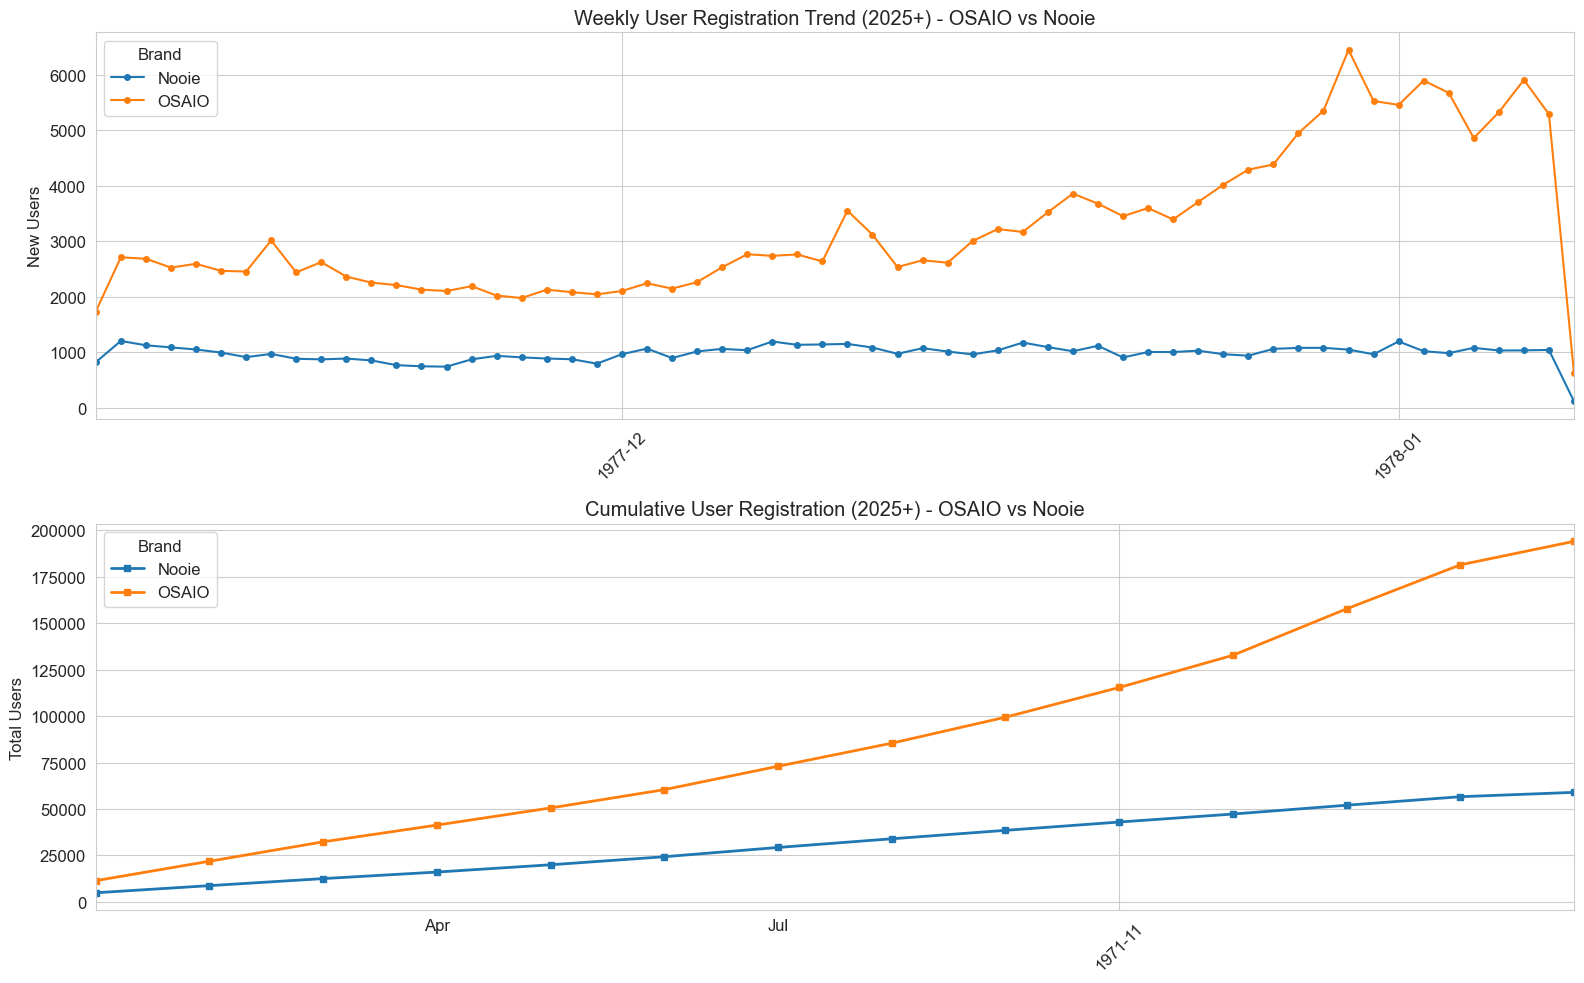


Monthly Registration:


brand,Nooie,OSAIO
register_month,,
2025-01-01,4948,11448
2025-02-01,3833,10470
2025-03-01,3782,10445
2025-04-01,3523,9001
2025-05-01,3922,9226
2025-06-01,4332,9839
2025-07-01,4983,12588
2025-08-01,4671,12418
2025-09-01,4543,13982


In [4]:
# 按周注册趋势 - OSAIO vs Nooie
weekly = df.groupby(['register_week', 'brand']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 周度趋势
weekly.index = weekly.index.to_timestamp()
weekly.plot(ax=axes[0], marker='o', markersize=4, linewidth=1.5)
axes[0].set_title('Weekly User Registration Trend (2025+) - OSAIO vs Nooie')
axes[0].set_xlabel('')
axes[0].set_ylabel('New Users')
axes[0].legend(title='Brand')
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)

# 月度累计趋势
monthly = df.groupby(['register_month', 'brand']).size().unstack(fill_value=0)
monthly.index = monthly.index.to_timestamp()
cumulative = monthly.cumsum()
cumulative.plot(ax=axes[1], linewidth=2, marker='s', markersize=5)
axes[1].set_title('Cumulative User Registration (2025+) - OSAIO vs Nooie')
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Users')
axes[1].legend(title='Brand')
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/user_registration_trend.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nMonthly Registration:')
monthly

In [5]:
# 按月汇总对比
monthly_summary = df.groupby(['register_month', 'brand']).size().unstack(fill_value=0)
monthly_summary['Total'] = monthly_summary.sum(axis=1)
if 'OSAIO' in monthly_summary.columns and 'Nooie' in monthly_summary.columns:
    monthly_summary['OSAIO_pct'] = (monthly_summary['OSAIO'] / monthly_summary['Total'] * 100).round(1)
    monthly_summary['Nooie_pct'] = (monthly_summary['Nooie'] / monthly_summary['Total'] * 100).round(1)
print('Monthly Registration Summary (2025+):')
monthly_summary

Monthly Registration Summary (2025+):


brand,Nooie,OSAIO,Total,OSAIO_pct,Nooie_pct
register_month,,,,,
2025-01,4948,11448,16396,69.80,30.20
2025-02,3833,10470,14303,73.20,26.80
2025-03,3782,10445,14227,73.40,26.60
2025-04,3523,9001,12524,71.90,28.10
2025-05,3922,9226,13148,70.20,29.80
2025-06,4332,9839,14171,69.40,30.60
2025-07,4983,12588,17571,71.60,28.40
2025-08,4671,12418,17089,72.70,27.30
2025-09,4543,13982,18525,75.50,24.50


## 3. 用户来源分析（自购设备 vs 被分享设备）

通过用户绑定的 **第一台设备** 的 `bind_type` 判定（按 `bind_time` 排序取最早）：
- `bind_type = 1` → 设备主人（买设备，通过说明书注册）
- `bind_type = 2` → 被分享用户（已有用户分享设备给他）

In [6]:
# 按第一台设备的 bind_type 判定用户来源
# first_time = 第一次绑定时间, bind_time = 最近一次绑定时间
sql_source = """
SELECT t.uid, t.bind_type as first_bind_type FROM (
    SELECT ud.uid, ud.bind_type,
           ROW_NUMBER() OVER (PARTITION BY ud.uid ORDER BY ud.first_time ASC) as rn
    FROM user_device ud
    INNER JOIN user u ON ud.uid = u.uid
    WHERE u.register_time >= 1735689600 AND ud.first_time > 0
) t WHERE t.rn = 1
"""

# OSAIO
db.switch_database('osaio')
src_osaio = db.query_df(sql_source)
src_osaio['brand'] = 'OSAIO'

# Nooie
db.switch_database('nooie')
src_nooie = db.query_df(sql_source)
src_nooie['brand'] = 'Nooie'

df_source = pd.concat([src_osaio, src_nooie], ignore_index=True)
df_source['source'] = df_source['first_bind_type'].map({1: 'Device Owner', 2: 'Shared User'}).fillna('Unknown')

print(f'OSAIO users with device: {len(src_osaio):,}')
print(f'Nooie users with device: {len(src_nooie):,}')

OSAIO users with device: 163,266
Nooie users with device: 39,944



OSAIO - User Acquisition Source:


,Source,Users,Pct %
0,Device Owner,135247,82.84
1,Shared User,28019,17.16



Nooie - User Acquisition Source:


,Source,Users,Pct %
0,Device Owner,29486,73.82
1,Shared User,10458,26.18


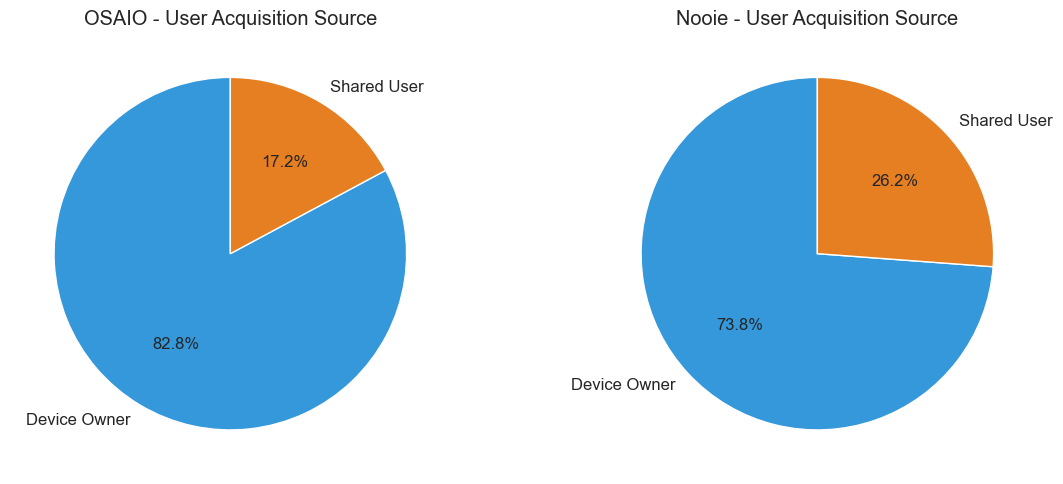

OSAIO: 194,048 total users, 163,266 have device (84.1%), 30,782 no device (15.9%)
Nooie: 58,974 total users, 39,944 have device (67.7%), 19,030 no device (32.3%)


In [7]:
# 用户来源分布
for brand in ['OSAIO', 'Nooie']:
    brand_src = df_source[df_source['brand'] == brand]
    dist = brand_src['source'].value_counts().reset_index()
    dist.columns = ['Source', 'Users']
    dist['Pct %'] = (dist['Users'] / dist['Users'].sum() * 100).round(2)
    print(f'\n{brand} - User Acquisition Source:')
    display(dist)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#3498db', '#e67e22']
for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_src = df_source[df_source['brand'] == brand]
    data = brand_src['source'].value_counts()
    axes[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].set_title(f'{brand} - User Acquisition Source')

plt.tight_layout()
plt.savefig('../reports/user_acquisition_source.png', dpi=150, bbox_inches='tight')
plt.show()

# 注意：没有绑定设备的注册用户
for brand in ['OSAIO', 'Nooie']:
    total_users = len(df[df['brand'] == brand])
    with_device = len(df_source[df_source['brand'] == brand])
    no_device = total_users - with_device
    print(f'{brand}: {total_users:,} total users, {with_device:,} have device ({with_device/total_users*100:.1f}%), {no_device:,} no device ({no_device/total_users*100:.1f}%)')

## 4. 注册用户7天绑定成功率

**KPI 定义**：注册后7天内成功绑定设备(bind_type=1)的用户占比（不含被分享用户）

- 分子：注册后7天内有 bind_type=1 且 first_time <= register_time + 7天 的用户
- 分母：总注册用户 - 被分享用户（第一台设备 bind_type=2）

In [8]:
# 7天绑定成功率 - 按月统计
# 排除最近7天注册的用户（还没到7天窗口期）
sql_bind_rate = """
SELECT 
    DATE_FORMAT(FROM_UNIXTIME(u.register_time), '%Y-%m') as reg_month,
    COUNT(DISTINCT u.uid) as total_users,
    COUNT(DISTINCT shared.uid) as shared_users,
    COUNT(DISTINCT bound.uid) as bound_in_7d
FROM user u
LEFT JOIN (
    SELECT t.uid FROM (
        SELECT ud.uid, ud.bind_type,
               ROW_NUMBER() OVER (PARTITION BY ud.uid ORDER BY ud.first_time ASC) as rn
        FROM user_device ud WHERE ud.first_time > 0
    ) t WHERE t.rn = 1 AND t.bind_type = 2
) shared ON u.uid = shared.uid
LEFT JOIN (
    SELECT DISTINCT ud.uid
    FROM user_device ud
    INNER JOIN user u2 ON ud.uid = u2.uid
    WHERE ud.bind_type = 1 
      AND ud.first_time > 0
      AND ud.first_time <= u2.register_time + 7*86400
      AND u2.register_time >= 1735689600
) bound ON u.uid = bound.uid
WHERE u.register_time >= 1735689600
  AND u.register_time <= UNIX_TIMESTAMP() - 7*86400
GROUP BY reg_month
ORDER BY reg_month
"""

bind_rates = {}
for brand in ['OSAIO', 'Nooie']:
    db.switch_database(brand.lower() if brand == 'Nooie' else 'osaio')
    br = db.query_df(sql_bind_rate)
    br['potential_owners'] = br['total_users'] - br['shared_users']
    br['bind_rate_7d'] = (br['bound_in_7d'] / br['potential_owners'] * 100).round(2)
    bind_rates[brand] = br
    
    overall = br['bound_in_7d'].sum() / br['potential_owners'].sum() * 100
    print(f'\n{brand} - 7天绑定成功率 (按月, 排除近7天注册用户):')
    display(br[['reg_month', 'total_users', 'shared_users', 'potential_owners', 'bound_in_7d', 'bind_rate_7d']])
    print(f'整体: {overall:.2f}%')


OSAIO - 7天绑定成功率 (按月, 排除近7天注册用户):


,reg_month,total_users,shared_users,potential_owners,bound_in_7d,bind_rate_7d
0,2025-01,11448,1134,10314,7352,71.28
1,2025-02,10470,1051,9419,6819,72.40
2,2025-03,10445,1072,9373,6855,73.14
3,2025-04,9001,1230,7771,5571,71.69
4,2025-05,9226,1366,7860,5809,73.91
5,2025-06,9839,1500,8339,6224,74.64
6,2025-07,12588,2001,10587,8439,79.71
7,2025-08,12418,1800,10618,8406,79.17
8,2025-09,13982,2026,11956,9863,82.49
9,2025-10,15988,2315,13673,11233,82.15


整体: 79.31%

Nooie - 7天绑定成功率 (按月, 排除近7天注册用户):


,reg_month,total_users,shared_users,potential_owners,bound_in_7d,bind_rate_7d
0,2025-01,4948,672,4276,2339,54.70
1,2025-02,3833,512,3321,1895,57.06
2,2025-03,3782,508,3274,1868,57.06
3,2025-04,3523,604,2919,1720,58.92
4,2025-05,3922,752,3170,1931,60.91
5,2025-06,4332,809,3523,2223,63.10
6,2025-07,4983,1127,3856,2477,64.24
7,2025-08,4671,1008,3663,2209,60.31
8,2025-09,4543,852,3691,2171,58.82
9,2025-10,4464,759,3705,2031,54.82


整体: 58.22%


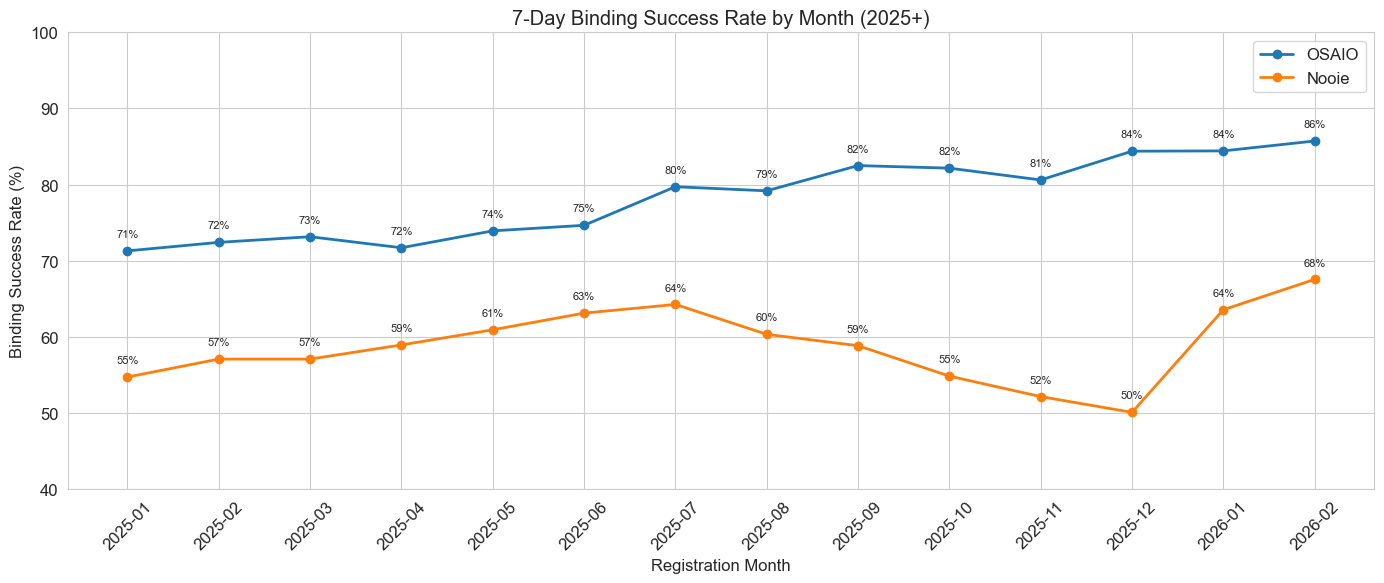

In [9]:
# 绑定成功率趋势图
fig, ax = plt.subplots(figsize=(14, 6))

for brand, br in bind_rates.items():
    ax.plot(br['reg_month'], br['bind_rate_7d'], marker='o', linewidth=2, markersize=6, label=brand)
    # 标注数值
    for _, row in br.iterrows():
        ax.annotate(f"{row['bind_rate_7d']:.0f}%", 
                    (row['reg_month'], row['bind_rate_7d']),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

ax.set_title('7-Day Binding Success Rate by Month (2025+)')
ax.set_xlabel('Registration Month')
ax.set_ylabel('Binding Success Rate (%)')
ax.legend()
ax.set_ylim(40, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/user_bind_success_rate.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 注册国家/地区分布

In [10]:
# 电话区号 → 国家名称映射 (EU重点国家)
COUNTRY_MAP = {
    '44': 'UK', '49': 'Germany', '33': 'France', '34': 'Spain',
    '39': 'Italy', '31': 'Netherlands', '32': 'Belgium', '43': 'Austria',
    '48': 'Poland', '351': 'Portugal', '353': 'Ireland', '46': 'Sweden',
    '45': 'Denmark', '47': 'Norway', '358': 'Finland', '41': 'Switzerland',
    '30': 'Greece', '36': 'Hungary', '40': 'Romania', '420': 'Czech Republic',
    '380': 'Ukraine', '7': 'Russia', '90': 'Turkey', '966': 'Saudi Arabia',
    '971': 'UAE', '972': 'Israel', '964': 'Iraq', '91': 'India',
    '1': 'US/Canada', '86': 'China', '81': 'Japan', '82': 'South Korea',
    '61': 'Australia', '55': 'Brazil', '52': 'Mexico', '254': 'Kenya',
    '506': 'Costa Rica', '1809': 'Dominican Rep',
}

df['country_name'] = df['register_country'].map(COUNTRY_MAP).fillna('Other(' + df['register_country'] + ')')


OSAIO - Top 15 Countries:


,country,count,pct
0,UK,66638,34.34
1,Italy,36476,18.80
2,Spain,26901,13.86
3,Germany,19129,9.86
4,France,14053,7.24
5,Iraq,4299,2.22
6,Netherlands,3814,1.97
7,Belgium,3424,1.76
8,Poland,3359,1.73
9,Portugal,2484,1.28



Nooie - Top 15 Countries:


,country,count,pct
0,UK,26888,45.59
1,Germany,13105,22.22
2,Spain,2079,3.53
3,Italy,1946,3.30
4,Austria,1913,3.24
5,Iraq,1578,2.68
6,Ireland,958,1.62
7,India,923,1.57
8,Saudi Arabia,907,1.54
9,Poland,705,1.20


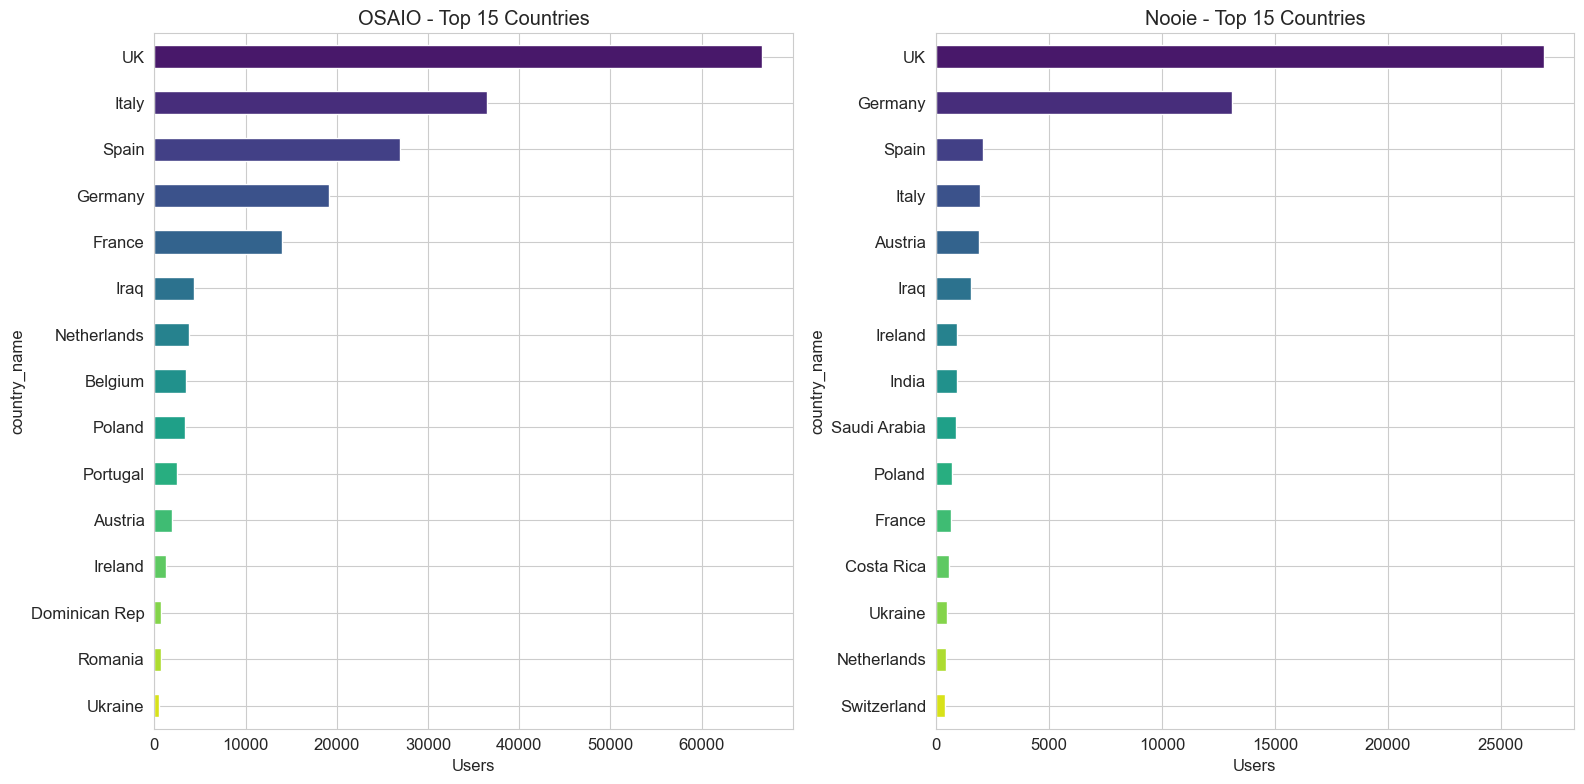

In [11]:
# Top 15 国家 - 双品牌对比
for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    country_dist = brand_df['country_name'].value_counts().head(15).reset_index()
    country_dist.columns = ['country', 'count']
    country_dist['pct'] = (country_dist['count'] / len(brand_df) * 100).round(2)
    print(f'\n{brand} - Top 15 Countries:')
    display(country_dist)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for i, brand in enumerate(['OSAIO', 'Nooie']):
    brand_df = df[df['brand'] == brand]
    top15 = brand_df['country_name'].value_counts().head(15)
    top15.plot(kind='barh', ax=axes[i], color=sns.color_palette('viridis', 15))
    axes[i].set_title(f'{brand} - Top 15 Countries')
    axes[i].set_xlabel('Users')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/user_country_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 用户增长率分析

In [ ]:
# 月度增长率 (MoM) - 当前月用日均量换算
import calendar

today = pd.Timestamp.now().normalize()
yesterday = today - pd.Timedelta(days=1)
current_month = today.to_period('M')
elapsed_days = yesterday.day  # 截止昨天的天数

for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    brand_monthly = brand_df.groupby('register_month').size()
    
    # 计算每月天数和日均
    monthly_detail = pd.DataFrame({'total': brand_monthly})
    monthly_detail['days'] = monthly_detail.index.map(
        lambda p: elapsed_days if p == current_month 
        else calendar.monthrange(p.year, p.month)[1]
    )
    monthly_detail['daily_avg'] = (monthly_detail['total'] / monthly_detail['days']).round(1)
    monthly_detail['daily_avg_growth_%'] = (monthly_detail['daily_avg'].pct_change() * 100).round(2)
    
    # 标记当前月
    monthly_detail['note'] = ''
    if current_month in monthly_detail.index:
        monthly_detail.loc[current_month, 'note'] = f'(截止{yesterday.strftime("%m-%d")}, {elapsed_days}天)'
    
    print(f'\n{brand} - 月度日均注册量及增长率:')
    display(monthly_detail[['total', 'days', 'daily_avg', 'daily_avg_growth_%', 'note']])

In [ ]:
# 增长率可视化 - 日均注册量 & 日均MoM增长率
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 上图：日均注册量趋势
for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    brand_monthly = brand_df.groupby('register_month').size()
    daily_avg = pd.DataFrame({'total': brand_monthly})
    daily_avg['days'] = daily_avg.index.map(
        lambda p: elapsed_days if p == current_month 
        else calendar.monthrange(p.year, p.month)[1]
    )
    daily_avg['daily_avg'] = daily_avg['total'] / daily_avg['days']
    daily_avg.index = daily_avg.index.to_timestamp()
    axes[0].plot(daily_avg.index, daily_avg['daily_avg'], label=brand, marker='o', linewidth=2, markersize=6)
    # 标注数值
    for idx, row in daily_avg.iterrows():
        axes[0].annotate(f"{row['daily_avg']:.0f}", (idx, row['daily_avg']),
                        textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)

axes[0].set_title('Daily Average Registration by Month (2025+)')
axes[0].set_ylabel('Daily Avg Users')
axes[0].legend()
axes[0].xaxis.set_major_locator(mdates.MonthLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)

# 下图：日均 MoM 增长率
for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    brand_monthly = brand_df.groupby('register_month').size()
    daily_avg = pd.DataFrame({'total': brand_monthly})
    daily_avg['days'] = daily_avg.index.map(
        lambda p: elapsed_days if p == current_month 
        else calendar.monthrange(p.year, p.month)[1]
    )
    daily_avg['daily_avg'] = daily_avg['total'] / daily_avg['days']
    growth = daily_avg['daily_avg'].pct_change() * 100
    growth.index = growth.index.to_timestamp()
    axes[1].plot(growth.index, growth.values, label=brand, marker='o', linewidth=2)

axes[1].set_title('Daily Avg Growth Rate (MoM %) — 2025+')
axes[1].set_ylabel('Growth Rate (%)')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].legend()
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/user_growth_rate.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. OSAIO vs Nooie 综合对比

In [14]:
# 综合对比表
summary = {}
for brand in ['OSAIO', 'Nooie']:
    brand_df = df[df['brand'] == brand]
    brand_src = df_source[df_source['brand'] == brand]
    br = bind_rates[brand]
    owner_cnt = len(brand_src[brand_src['source'] == 'Device Owner'])
    shared_cnt = len(brand_src[brand_src['source'] == 'Shared User'])
    with_device = len(brand_src)
    no_device = len(brand_df) - with_device
    overall_bind = br['bound_in_7d'].sum() / br['potential_owners'].sum() * 100
    
    summary[brand] = {
        'Total Users': len(brand_df),
        'Device Owners': owner_cnt,
        'Shared Users': shared_cnt,
        'No Device Users': no_device,
        'Share Rate %': round(shared_cnt / max(with_device, 1) * 100, 2),
        '7d Bind Rate %': round(overall_bind, 2),
        'Unique Countries': brand_df['register_country'].nunique(),
        'Top Country': brand_df['country_name'].value_counts().index[0],
        'Last 30d New Users': len(brand_df[brand_df['register_date'] >= pd.Timestamp.now() - pd.Timedelta(days=30)]),
        'Last 90d New Users': len(brand_df[brand_df['register_date'] >= pd.Timestamp.now() - pd.Timedelta(days=90)]),
    }

summary_df = pd.DataFrame(summary)
print('OSAIO vs Nooie - User Summary (2025+):')
summary_df

OSAIO vs Nooie - User Summary (2025+):


,OSAIO,Nooie
Total Users,194048,58974
Device Owners,135247,29486
Shared Users,28019,10458
No Device Users,30782,19030
Share Rate %,17.16,26.18
7d Bind Rate %,79.31,58.22
Unique Countries,150,142
Top Country,UK,UK
Last 30d New Users,23488,4596
Last 90d New Users,69316,13502


## 8. 生成报告

In [15]:
# 生成 Markdown 报告
report = f"""# EU区用户分析报告 (2025年至今)

**生成时间**: {datetime.now().strftime('%Y-%m-%d %H:%M')}  
**数据范围**: 2025-01-01 至今

## 概览

| 指标 | OSAIO | Nooie |
|------|-------|-------|
| 总用户数 | {summary['OSAIO']['Total Users']:,} | {summary['Nooie']['Total Users']:,} |
| 设备主人(自购) | {summary['OSAIO']['Device Owners']:,} | {summary['Nooie']['Device Owners']:,} |
| 被分享用户 | {summary['OSAIO']['Shared Users']:,} | {summary['Nooie']['Shared Users']:,} |
| 无设备用户 | {summary['OSAIO']['No Device Users']:,} | {summary['Nooie']['No Device Users']:,} |
| 分享率 | {summary['OSAIO']['Share Rate %']}% | {summary['Nooie']['Share Rate %']}% |
| 7天绑定成功率 | {summary['OSAIO']['7d Bind Rate %']}% | {summary['Nooie']['7d Bind Rate %']}% |
| 覆盖国家数 | {summary['OSAIO']['Unique Countries']} | {summary['Nooie']['Unique Countries']} |
| 最大市场 | {summary['OSAIO']['Top Country']} | {summary['Nooie']['Top Country']} |
| 近30天新增 | {summary['OSAIO']['Last 30d New Users']:,} | {summary['Nooie']['Last 30d New Users']:,} |
| 近90天新增 | {summary['OSAIO']['Last 90d New Users']:,} | {summary['Nooie']['Last 90d New Users']:,} |

## 图表

- 注册趋势: `reports/user_registration_trend.png`
- 用户来源: `reports/user_acquisition_source.png`
- 绑定成功率: `reports/user_bind_success_rate.png`
- 国家分布: `reports/user_country_distribution.png`
- 增长率: `reports/user_growth_rate.png`
"""

with open('../reports/01_user_analysis_report.md', 'w') as f:
    f.write(report)

print('Report saved to: reports/01_user_analysis_report.md')

Report saved to: reports/01_user_analysis_report.md


In [16]:
# 关闭连接
db.close()
print('Done!')

Done!
